In [2]:
import pandas as pd
from fastai.tabular.all import RandomSplitter
from fastai.tabular.all import TabularPandas
from fastai.tabular.all import range_of
from fastai.tabular.all import Categorify, FillMissing,Normalize, CategoryBlock, tabular_learner, accuracy, ClassificationInterpretation
import matplotlib.pyplot as plt
import json
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import seaborn as sns

In [3]:
with open('../../Odin/odin-col-dict.json', "r") as json_file:
    choice_dict = json.load(json_file)

In [4]:
# df = pd.read_pickle('Odin2FelyxAms')
df = pd.read_pickle('../../Odin/Odin2Ams')
# df = pd.read_pickle('Odin2bunched')
df.fillna(0, inplace = True)
dep_var = 'khvm'
categorical_columns = [col for col in df.columns if df.dtypes[col] == object]
categorical_columns.remove(dep_var)
numerical_columns = [col for col in df.columns if df.dtypes[col] != object]

In [5]:
print(len(df))
print(df.dtypes)

15520
hhpers            object
hhsam             object
hhlft1            object
hhlft2            object
hhlft3            object
hhlft4            object
geslacht          object
leeftijd          object
herkomst          object
betwerk           object
onbbez            object
opleiding         object
hhgestinkg        object
oprijbewijsau     object
hhauto            object
brandstofpa1      object
brandstofepa1     object
brandstofpa2      object
brandstofepa2     object
hhefiets          object
ovstkaart         object
weekdag           object
feestdag          object
doel              object
kmotiefv          object
vertpc            object
aankpc            object
khvm              object
choice_dur         int64
choice_dist        int64
bike_dur         float64
bike_dist        float64
car_dur          float64
car_dist         float64
pt_dur           float64
pt_dist          float64
walk_dur         float64
walk_dist        float64
hour              object
dtype: object


In [7]:
sdf = df[numerical_columns + categorical_columns + [dep_var]]

sdf.khvm = sdf.khvm.astype(str)
sdf = sdf.replace({"khvm": {'3':'4'}})
sdf = sdf.replace({"khvm": {'2':'1'}})
sdf = sdf[sdf.khvm != '7']
sdf = sdf.replace({"khvm": choice_dict['khvm']})

In [8]:
splits = RandomSplitter(valid_pct=0.2)(range_of(sdf))
to = TabularPandas(sdf, procs=[Categorify, FillMissing ,Normalize],
                   cat_names= categorical_columns, cont_names= numerical_columns,
                   y_names= dep_var,
                   splits=splits, y_block = CategoryBlock)

dls = to.dataloaders()
dls.show_batch()

,hhpers,hhsam,hhlft1,hhlft2,hhlft3,hhlft4,geslacht,leeftijd,herkomst,betwerk,onbbez,opleiding,hhgestinkg,oprijbewijsau,hhauto,brandstofpa1,brandstofepa1,brandstofpa2,brandstofepa2,hhefiets,ovstkaart,weekdag,feestdag,doel,kmotiefv,vertpc,aankpc,hour,choice_dur,choice_dist,bike_dur,bike_dist,car_dur,car_dist,pt_dur,pt_dist,walk_dur,walk_dist,khvm
0,2,2,0,0,0,2,2,24,1,3,0,4,9,1,1,1,0,7,6,0,0,4,0,1,1,1021,1689,18,2999.999987,44999.999531,8194.999931,37815.961217,2277.999968,44929.801376,0.000134,-0.000036,-0.000004,-0.000044,Personenauto - bestuurder
1,2,2,0,0,0,2,1,70,1,0,2,3,1,1,0,7,6,7,6,0,4,7,0,12,7,1015,3956,12,6299.999831,80000.000323,14235.000181,65093.998512,4127.000089,76343.003086,7478.000140,73016.999457,-0.000004,-0.000044,Personenauto - bestuurder
2,6,3,1,2,1,2,1,45,1,3,0,4,10,1,1,1,0,7,6,0,4,2,0,1,1,1017,1851,17,2700.000009,40299.999559,9916.000146,45121.999213,0.000002,-0.000474,4081.999938,40283.999400,-0.000004,-0.000044,Bus/tram/metro
3,1,1,0,0,0,1,1,41,1,3,0,4,8,1,1,7,6,7,6,0,4,3,0,1,1,1043,3522,17,2999.999987,45599.999564,10335.000246,47696.000258,2607.999976,47472.000341,4196.000001,48816.999231,-0.000004,-0.000044,Bus/tram/metro
4,4,3,0,2,0,2,2,42,1,3,0,4,9,1,2,1,0,1,0,0,4,6,0,1,4,1058,1057,9,600.000050,1800.000601,382.000068,1417.309505,365.000035,1541.780519,482.999948,1374.614744,1070.999959,1330.119947,Fiets
5,1,1,0,0,0,1,1,25,3,0,3,3,2,0,0,7,6,7,6,0,0,6,0,1,5,1081,2032,13,1500.000013,21299.999949,4082.000000,18872.000000,1549.000001,20800.000018,2905.999993,20430.000007,-0.000004,-0.000044,Bus/tram/metro
6,5,3,1,2,0,2,2,33,3,0,1,3,2,1,1,1,0,7,6,0,0,6,0,1,9,1055,1064,9,1800.000019,3000.000668,799.999860,3116.930465,772.000027,3787.199716,1238.000023,3711.279032,2434.000001,3039.020015,Te voet
7,2,6,0,0,0,2,1,60,1,2,0,4,4,0,0,7,6,7,6,0,4,5,0,2,1,1072,1078,13,899.999946,1700.000306,332.999878,1294.540455,453.000018,1853.970042,675.999951,1360.473090,1026.999962,1283.839923,Fiets
8,4,3,0,2,0,2,1,41,1,3,0,3,9,1,3,1,0,7,6,0,4,4,0,1,1,1055,2131,15,1199.999952,22999.999999,3600.999982,16064.530225,1532.000000,25012.640713,0.000134,-0.000036,12248.000316,15795.330163,Personenauto - bestuurder
9,3,6,0,0,2,1,1,15,1,0,3,0,2,0,1,1,0,7,6,0,0,5,0,1,5,1382,1383,16,600.000050,1200.000568,1063.000053,4513.999471,1080.999984,5594.000178,2992.000006,6888.999663,3572.999978,4472.000023,Fiets


SuggestedLRs(valley=0.0012022644514217973)

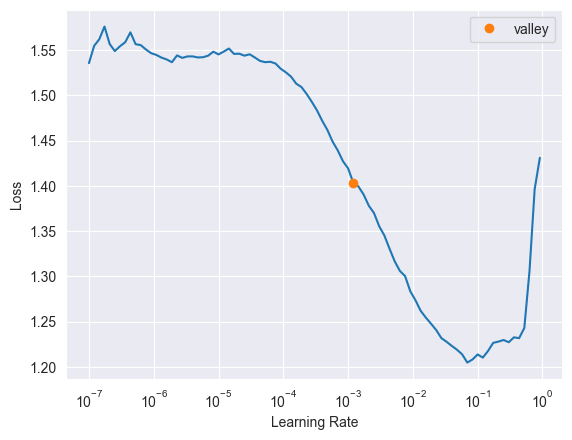

In [9]:
learn = tabular_learner(dls, metrics=accuracy)
learn.lr_find()

In [23]:
learn.fit_one_cycle(4, learn.lr)

In [24]:
interp = ClassificationInterpretation.from_learner(learn)
interp.print_classification_report()

                           precision    recall  f1-score   support

           Bus/tram/metro       0.72      0.70      0.71       843
                    Fiets       0.69      0.73      0.71       849
Personenauto - bestuurder       0.77      0.81      0.79      1109
                  Te voet       0.52      0.32      0.39       183

                 accuracy                           0.72      2984
                macro avg       0.68      0.64      0.65      2984
             weighted avg       0.72      0.72      0.72      2984



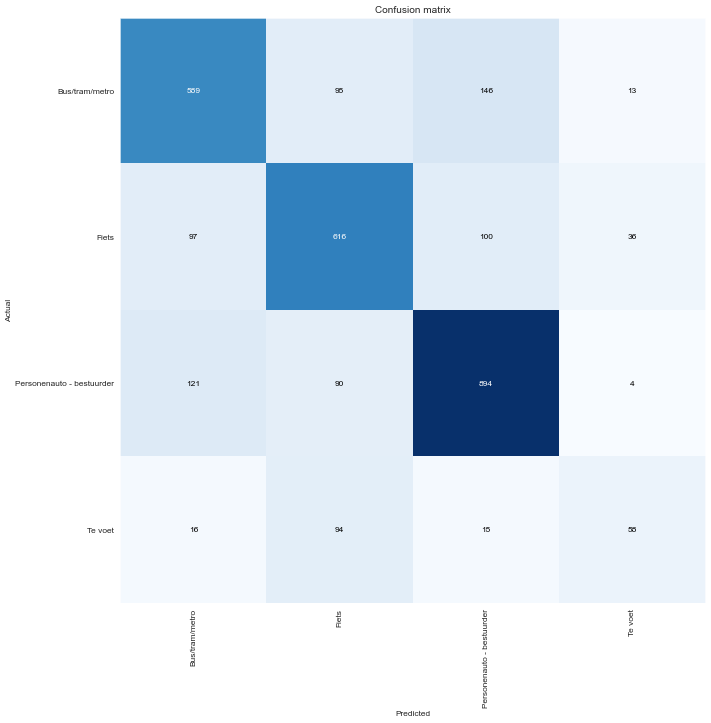

In [25]:
interp.plot_confusion_matrix(figsize=(12,12), dpi=60)

In [25]:
Saving n Loading
# # learn.save('fastaiamsmodel')
# learn.export('fastaiamsmodel.pkl')
# from fastai.tabular.all import load_learner
# abbb = load_learner('fastaiamsmodel.pkl')
# interp = ClassificationInterpretation.from_learner(abbb)
# # interp.print_classification_report()

In [26]:
#Create a Dicitonary containing the embedding matrix for every categorical variable
embedding_matrices = [embed.weight for embed in learn.model.embeds]
embedding_matrices
category_names = [k for k,v in learn.dls.classes.items()]
categ_dictionary = dict(zip(category_names, embedding_matrices))

In [27]:
for i in categ_dictionary.keys():
    print (i ,': ' , categ_dictionary[i].shape)

hhpers :  torch.Size([11, 6])
hhsam :  torch.Size([9, 5])
hhlft1 :  torch.Size([6, 4])
hhlft2 :  torch.Size([5, 4])
hhlft3 :  torch.Size([6, 4])
hhlft4 :  torch.Size([9, 5])
geslacht :  torch.Size([3, 3])
leeftijd :  torch.Size([89, 20])
herkomst :  torch.Size([4, 3])
betwerk :  torch.Size([6, 4])
onbbez :  torch.Size([10, 6])
opleiding :  torch.Size([8, 5])
hhgestinkg :  torch.Size([12, 6])
oprijbewijsau :  torch.Size([3, 3])
hhauto :  torch.Size([11, 6])
brandstofpa1 :  torch.Size([6, 4])
brandstofepa1 :  torch.Size([6, 4])
brandstofpa2 :  torch.Size([6, 4])
brandstofepa2 :  torch.Size([6, 4])
hhefiets :  torch.Size([3, 3])
ovstkaart :  torch.Size([6, 4])
weekdag :  torch.Size([8, 5])
feestdag :  torch.Size([3, 3])
doel :  torch.Size([15, 7])
kmotiefv :  torch.Size([10, 6])
vertpc :  torch.Size([1056, 79])
aankpc :  torch.Size([1040, 78])
hour :  torch.Size([25, 10])


In [28]:
choice_dict.keys()

dict_keys(['aankpc', 'betwerk', 'brandstofepa1', 'brandstofepa2', 'brandstofpa1', 'brandstofpa2', 'doel', 'feestdag', 'gemgr', 'geslacht', 'herkomst', 'hhauto', 'hhefiets', 'hhgestinkg', 'hhlft1', 'hhlft2', 'hhlft3', 'hhlft4', 'hhpers', 'hhsam', 'khvm', 'kmotiefv', 'leeftijd', 'onbbez', 'opleiding', 'oprijbewijsau', 'ovstkaart', 'prov', 'sted', 'vertpc', 'weekdag', 'wogem'])

In [51]:
def plotembed(categ = 'weekdag', lablength = 10,
              fontsize = 8, redmet = 'PCA'):
    embedding_matrix = categ_dictionary[categ].cpu().detach().numpy()
    labels = learn.dls.classes[categ]

    # Give it the category name if the info is in the JSON
    if categ in choice_dict.keys():
        labels = [choice_dict[categ].get(item, item)[:lablength] for item in [str(lab) for lab in labels]]
    else:
        labels = [str(lab)[:lablength] for lab in labels]
    if redmet == 'PCA':
        pca = PCA(n_components=2)
        mat_2d = pca.fit_transform(embedding_matrix)
    else:
        tsne = TSNE(n_components=2, perplexity = 10)
        mat_2d = tsne.fit_transform(embedding_matrix)

    max_per_cat = sdf.groupby([categ, 'khvm'], as_index=False)['feestdag'].count().groupby(categ).apply(lambda x: x.khvm[x.feestdag.idxmax()])

    PlotData = pd.DataFrame({'pca1': mat_2d[1:, 0], 'pca2': mat_2d[1:, 1],
                       categ: labels[1:],
                       'mc': list(max_per_cat.values)})

    PlotData = PlotData[PlotData[categ].isin(APC)]
    sns.scatterplot(data = PlotData, x = 'pca1', y = 'pca2', hue = 'mc')


    for i in PlotData.index:
    # for i in range(len(da)):
    #     plt.text(da.iloc[i,0], da.iloc[i,1], labels[i+1])
    #     plt.text(da.iloc[i,0], da.iloc[i,1], da.to_embed.loc[i])
        plt.text(PlotData.pca1.loc[i], PlotData.pca2.loc[i], PlotData[categ][i], fontsize=fontsize)

    plt.title("2D Array Plot as Text Labels")
    plt.xlabel("X-axis")
    plt.ylabel("Y-axis")
    plt.show()

    return PlotData

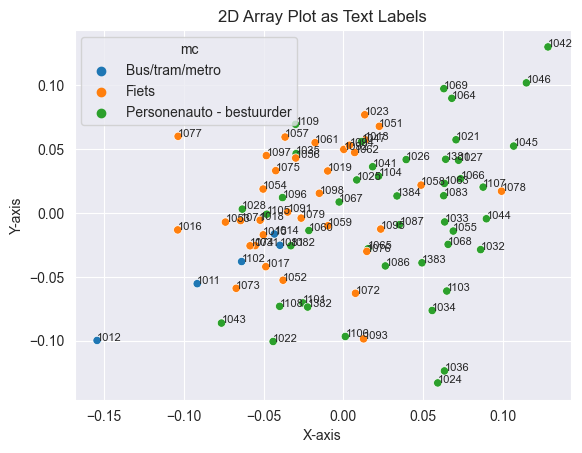

In [54]:
embeddingdf = plotembed('aankpc', lablength = 30)

In [35]:
import geopandas as gpd
print(len(df.vertpc.unique()))
jj = gpd.read_file('../../PublicGeoJsons/AmsPCs.json')
jj.Postcode4 =jj.Postcode4.astype(str)
APC = list(jj.Postcode4.unique())


1084


In [110]:
embeddingsdict = dict()
for categ in categ_dictionary.keys():
    matrix = categ_dictionary[categ].cpu().detach().numpy()
    embeddingsdf = pd.DataFrame(matrix).drop(0, axis = 0)
    embeddingsdf.index= list(sdf[categ].unique())
    embeddingsdict[categ] = embeddingsdf
embeddingsdict

{'hhpers':            0         1         2         3         4         5
 3   0.010488  0.025608 -0.018113  0.011499 -0.020860  0.007494
 4  -0.023457 -0.008719  0.008738 -0.013154 -0.023652 -0.009329
 5   0.004681 -0.036142  0.030436  0.002075  0.043348 -0.000274
 2  -0.038388 -0.005679 -0.036716  0.035285 -0.010207  0.043754
 1   0.034201  0.022267  0.015743 -0.001238 -0.009652 -0.018067
 6  -0.021447  0.040529  0.004482  0.037237  0.061551 -0.014808
 10 -0.062618 -0.045892  0.088020  0.045953  0.013830  0.029065
 8   0.053591 -0.027011 -0.077643 -0.026536 -0.042725  0.050101
 7   0.052348 -0.009400 -0.024897 -0.036180 -0.051834  0.059481
 9  -0.029635 -0.043414  0.037432 -0.058325 -0.007033  0.007645,
 'hhsam':           0         1         2         3         4
 6 -0.014737  0.018944  0.012656 -0.012140  0.016346
 3  0.048000 -0.032412 -0.012802  0.033030  0.010712
 4 -0.057741 -0.026610  0.016492  0.011179 -0.011200
 2  0.070069 -0.028690  0.015557  0.046660  0.056067
 1 -0.01921

In [111]:
# embeddingsdict.to_pickle('embeddingsdict')
import pickle
with open('embeddingsdict', 'wb') as f:
    pickle.dump(embeddingsdict, f)